## Library and Data Importing

In [1]:
# Standard Python Libraries
import numpy as np
import pandas as pd

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Preprocessing Libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Dimensionality Reduction Libraries
from sklearn.decomposition import PCA
import umap  # UMAP algorithm

# Clustering Libraries
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Data Profiling Libraries
from ydata_profiling import ProfileReport  # For automated EDA (Exploratory Data Analysis)
import missingno as msno  # For visualizing missing values

# Custom Helper Functions
from helper_functions import print_boxed_text, save_boxed_text_to_file, phi_coefficient, one_hot_encode, standardize_numeric


/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/leo/Programming/PLR/Leo/env/lib/python3.11/site-packages/umap/d

In [2]:
#import the data
data = pd.read_csv('data/cleaned_data_SYMPTOMS_9_13_23_DNA.csv')

## Data Exploration

In [3]:
data.shape

(4196, 174)

In [4]:
#check the types of data
data.dtypes

Symptom_Memory_short              float64
Symptom_Memory_long               float64
Symptom_Memory_no_new_memories    float64
Symptom_Memory_forget_tasks       float64
Symptom_Memory_other              float64
                                   ...   
FAS                               float64
FAS_cat                            object
Physical_PEM_Severity             float64
Cognitive_PEM_Severity            float64
HasPeriods                         object
Length: 174, dtype: object

<Axes: >

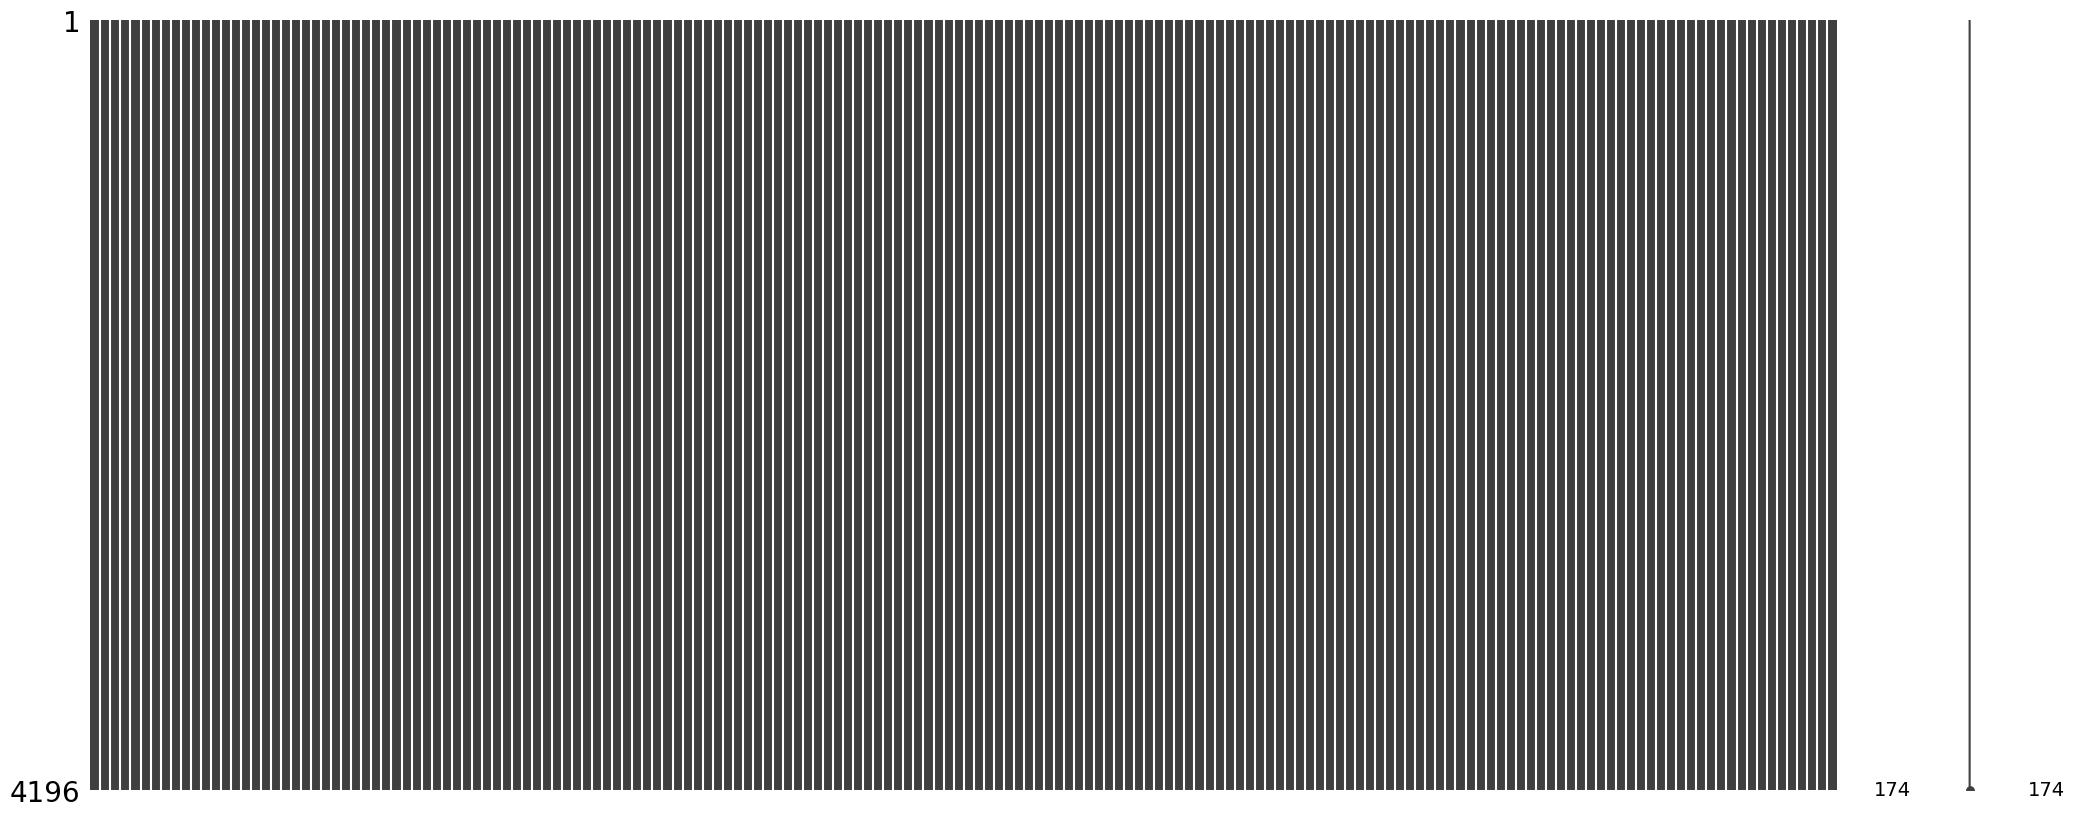

In [5]:
msno.matrix(data)

In [6]:
# Generate the profiling report
#profile = ProfileReport(data)

# Save the report to an HTML file
#profile.to_file(output_file='report.html')

#profile.to_notebook_iframe()

### Handling Demographic Data



#### Evaluating the Validity of New Variables for Clustering

Given that we have newly introduced variables in our dataset—some of which are string types and others are numeric non-binary—we need to assess their validity in contributing to our clustering objectives. Here's how we will proceed:

#### 1. Separate New Variables into Their Own DataFrame

First, we will separate the new non-binary features, along with any features whose names start with "Demographic", into their own DataFrame. This will allow us to focus solely on these variables without disrupting the original work done on the dataset containing only binary features.

#### 2. Analyse Clustering Performance with New Variables

Cluster the Demographics dataFrame in onjuction with select features from the original dataframe


In [7]:
print(f'original data shape: {data.shape}')
print(f'number of nan values: {data.isna().sum().sum()}')
# 0. Remove all NaN values
data = data.dropna()

# 1. Remove non-binary and string columns into a separate DataFrame
binary_columns = [col for col in data.columns if data[col].nunique() == 2]
non_binary_columns = list(set(data.columns) - set(binary_columns))
non_binary_data = data[non_binary_columns]
data = data.drop(columns=non_binary_columns)

# 2. One-hot encode the string columns where applicable
object_cols = non_binary_data.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_attrs = encoder.fit_transform(non_binary_data[object_cols])
encoded_df = pd.DataFrame(encoded_attrs, columns=encoder.get_feature_names_out(object_cols))
non_binary_data = pd.concat([non_binary_data.drop(object_cols, axis=1), encoded_df], axis=1)

# 3. Standardize the columns that are numeric and not binary
scaler = StandardScaler()
numeric_cols = non_binary_data.select_dtypes(include=['float64', 'int64']).columns
numeric_cols_to_standardize = [col for col in numeric_cols if non_binary_data[col].mean() > 1]
non_binary_data[numeric_cols_to_standardize] = scaler.fit_transform(non_binary_data[numeric_cols_to_standardize])

# 4. Neatly print which columns were one-hot encoded and how many unique values they had
print("One-hot encoded columns:")
for col in object_cols:
    print(f" - {col} (nunique: {non_binary_data[col].nunique() if col in non_binary_data else 'Encoded'})")

# 5. Neatly print which columns have been standardized
print("\nStandardized columns:")
for col in numeric_cols_to_standardize:
    print(f" - {col}")

# 6. Save the new subset DataFrame to .csv
non_binary_data.to_csv('data/non_binary_data_processed.csv', index=False)

print(f'data shape after preprocessing: {data.shape}')

print("\nSaved the processed non-binary data to 'data/non_binary_data_processed.csv'.")


original data shape: (4196, 174)
number of nan values: 0
One-hot encoded columns:
 - Demographics_Gender_Cleaned (nunique: Encoded)
 - HasPeriods (nunique: Encoded)
 - Demographics_Ancestry_Cleaned (nunique: Encoded)
 - Demographics_Age_Cleaned (nunique: Encoded)
 - Flag_POTS (nunique: Encoded)
 - FAS_cat (nunique: Encoded)

Standardized columns:
 - Cognitive_PEM_Severity
 - Physical_PEM_Severity
 - FAS
data shape after preprocessing: (4196, 163)

Saved the processed non-binary data to 'data/non_binary_data_processed.csv'.


In [8]:
demo = pd.read_csv('data/non_binary_data_processed.csv')

#show all columns
pd.set_option('display.max_columns', None)

demo.head()

,Cognitive_PEM_Severity,Physical_PEM_Severity,FAS,Flag_MCAS,Symptom_PEM,Demographics_Gender_Cleaned_Man,Demographics_Gender_Cleaned_Non-binary/Genderqueer/Gender non-conforming,Demographics_Gender_Cleaned_Woman,"HasPeriods_No, other reason","HasPeriods_No, post-menopausal",HasPeriods_Yes,"Demographics_Ancestry_Cleaned_Asian, South Asian, South East Asian",Demographics_Ancestry_Cleaned_Black,"Demographics_Ancestry_Cleaned_Hispanic, Latino, or Spanish Origin","Demographics_Ancestry_Cleaned_Multiple ancestries, including white","Demographics_Ancestry_Cleaned_Multiple ancestries, not including white",Demographics_Ancestry_Cleaned_Other,Demographics_Ancestry_Cleaned_White,Demographics_Age_Cleaned_18-29,Demographics_Age_Cleaned_30-39,Demographics_Age_Cleaned_40-49,Demographics_Age_Cleaned_50-59,Demographics_Age_Cleaned_60-69,Demographics_Age_Cleaned_70-79,Demographics_Age_Cleaned_80+,"Flag_POTS_Definite, measured bpm > 30","Flag_POTS_Likely, had higher bpm standing","Flag_POTS_No, no tachycardia","Flag_POTS_Possible, had tachycardia/palpitations",FAS_cat_Fatigue,FAS_cat_Minimal/No Fatigue,FAS_cat_Substantial Fatigue
0,0.397753,0.577680,0.279849,0.0,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-1.895241,0.103698,-1.156361,0.0,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.584959,-0.370285,-1.299982,0.0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.895241,1.051663,-1.156361,0.0,1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-0.584959,-1.318250,-0.438256,1.0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


## Remove Uninformative Variables

In [9]:
def drop_skewed_features(df, threshold=0.9):
    """
    Drop features that are skewed towards 0 or 1.
    
    Parameters:
        df (DataFrame): The input DataFrame with binary features.
        threshold (float): The skewness threshold. Features with skewness above this value will be dropped.
        
    Returns:
        DataFrame: A new DataFrame with skewed features removed.
    """
    lines = ["Dropped Skewed Features"]
    is_title = [True]
    
    dropped_features = []
    
    for col in df.columns:
        # Calculate the skewness for each feature
        skewness = df[col].mean()
        
        # Check if the feature is skewed towards 0 or 1
        if skewness > threshold or skewness < (1 - threshold):
            line = f"Dropping {col} with skewness {skewness:.4f}"
            lines.append(line)
            is_title.append(False)
            dropped_features.append(col)
            
    # Drop the skewed features
    df_dropped = df.drop(columns=dropped_features)
    
    print_boxed_text(lines, is_title)
    
    return df_dropped


threshold = 0.95  #Setting this to a very conservative 95% threshold would be good to discuss this as a team
data_unskewed = drop_skewed_features(data, threshold)

┌────────────────────────────────────────────────────────────────────────────────┐
├────────────────────────────────────────────────────────────────────────────────┤
│                            Dropped Skewed Features                             │
├────────────────────────────────────────────────────────────────────────────────┤
│                                                                                │
│ Dropping Symptom_Speech_other with skewness 0.0472                             │
│ Dropping Symptom_Heightened_taste with skewness 0.0348                         │
│ Dropping Symptom_Hallucinations_tactile with skewness 0.0374                   │
│ Dropping Symptom_Hallucinations_other with skewness 0.0226                     │
│ Dropping Symptom_Sensations_facial_paralysis with skewness 0.0341              │
│ Dropping Symptom_New_anaphylaxis with skewness 0.0472                          │
│ Dropping Symptom_Coughing_up_blood with skewness 0.0484                        │
│ Dr

## Correlation Analysis

$$\Phi = \frac{(ad - bc)}{\sqrt{(a + b)(a + c)(b + d)(c + d)}}$$



I went with the Phi coefficient to figure out which symptoms are related because it's useful when working with binary data like ours. It's simple to interpret and commputationally efficient. The formula essentially captures the difference between the observed frequency of coincident events and the frequency that would be expected if the variables were independent, normalized by what the maximum possible difference could be. This makes it an intuitive measure of how much one variable depends on another.

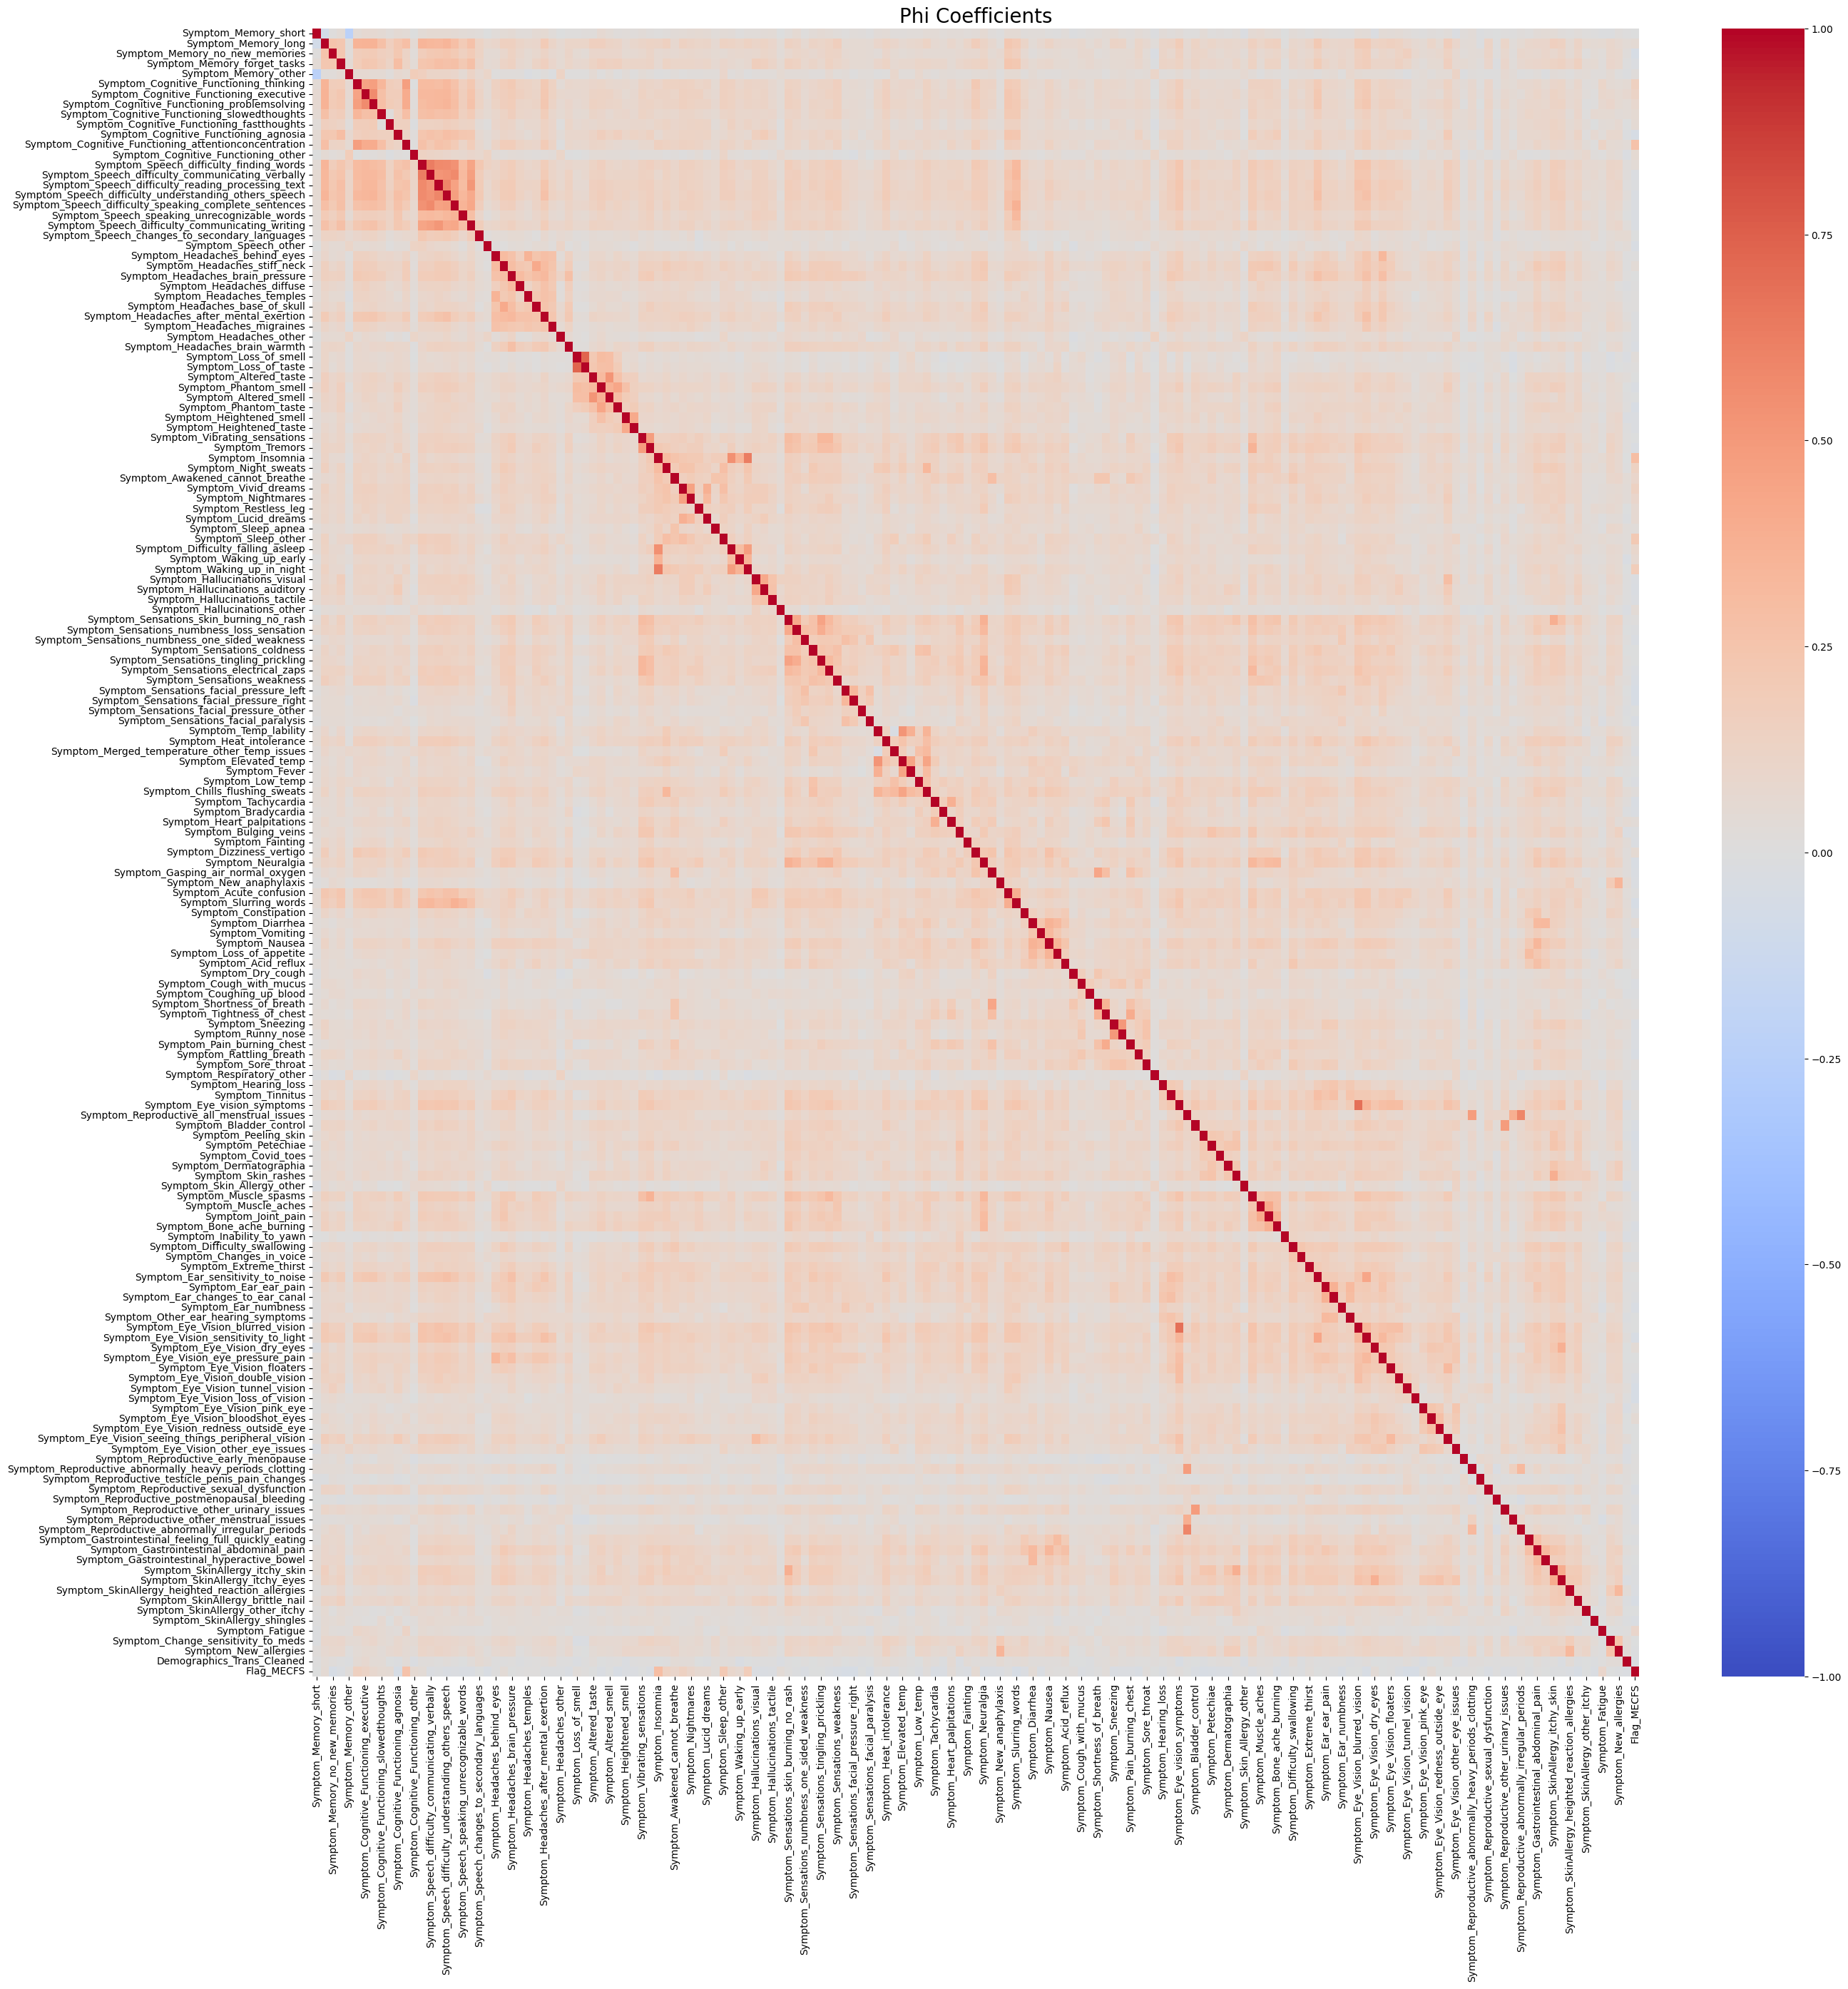

In [10]:
# Remove columns with only one unique value
data_unskewed = data_unskewed.loc[:, data.nunique() != 1]



# Initialize an empty dataframe to store phi values
phi_values = pd.DataFrame(index=data.columns, columns=data.columns)

# Calculate phi values
for col1 in data.columns:
    for col2 in data.columns:
        contingency_table = pd.crosstab(data[col1], data[col2])
        phi = phi_coefficient(contingency_table)
        phi_values.loc[col1, col2] = phi

# Convert to float
phi_values = phi_values.astype(float)

# Plot heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(phi_values, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Phi Coefficients", fontsize=20)
plt.show()

In [11]:
threshold = 0.5  # I decided to set this to 0.5 just based off what feels right, would be interesting to get some clinical input on this.
to_drop = []
for col1 in data_unskewed.columns:
    for col2 in data_unskewed.columns:
        if col1 >= col2:  # This ensures each pair is only considered once
            continue
        phi_value = abs(phi_values.loc[col1, col2])
        if phi_value > threshold:
            to_drop.append((col1, col2, phi_value))

# Sort the list so that the same columns are dropped each time
to_drop.sort(key=lambda x: x[2], reverse=True)  # Sort by phi_value

dropped_columns = set()
for col1, col2, phi_value in to_drop:
    if col1 not in dropped_columns and col2 not in dropped_columns:
        dropped_columns.add(col1)


dropped_columns = set()
lines = ["Dropped Columns and Their Phi Coefficients"]
is_title = [True]
for col1, col2, phi_value in to_drop:
    if col1 not in dropped_columns and col2 not in dropped_columns:
        lines.append(f"Dropping column '{col1}' which has a phi coefficient of {phi_value} with '{col2}'")
        is_title.append(False)
        dropped_columns.add(col1)
print_boxed_text(lines, is_title)

data_drop_corr = data_unskewed.drop(columns=dropped_columns)
#data_drop_corr = data_unskewed

┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                                     Dropped Columns and Their Phi Coefficients                                                                     │
├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                                                                                                                    │
│ Dropping column 'Symptom_Loss_of_smell' which has a phi coefficient of 0.7301896617

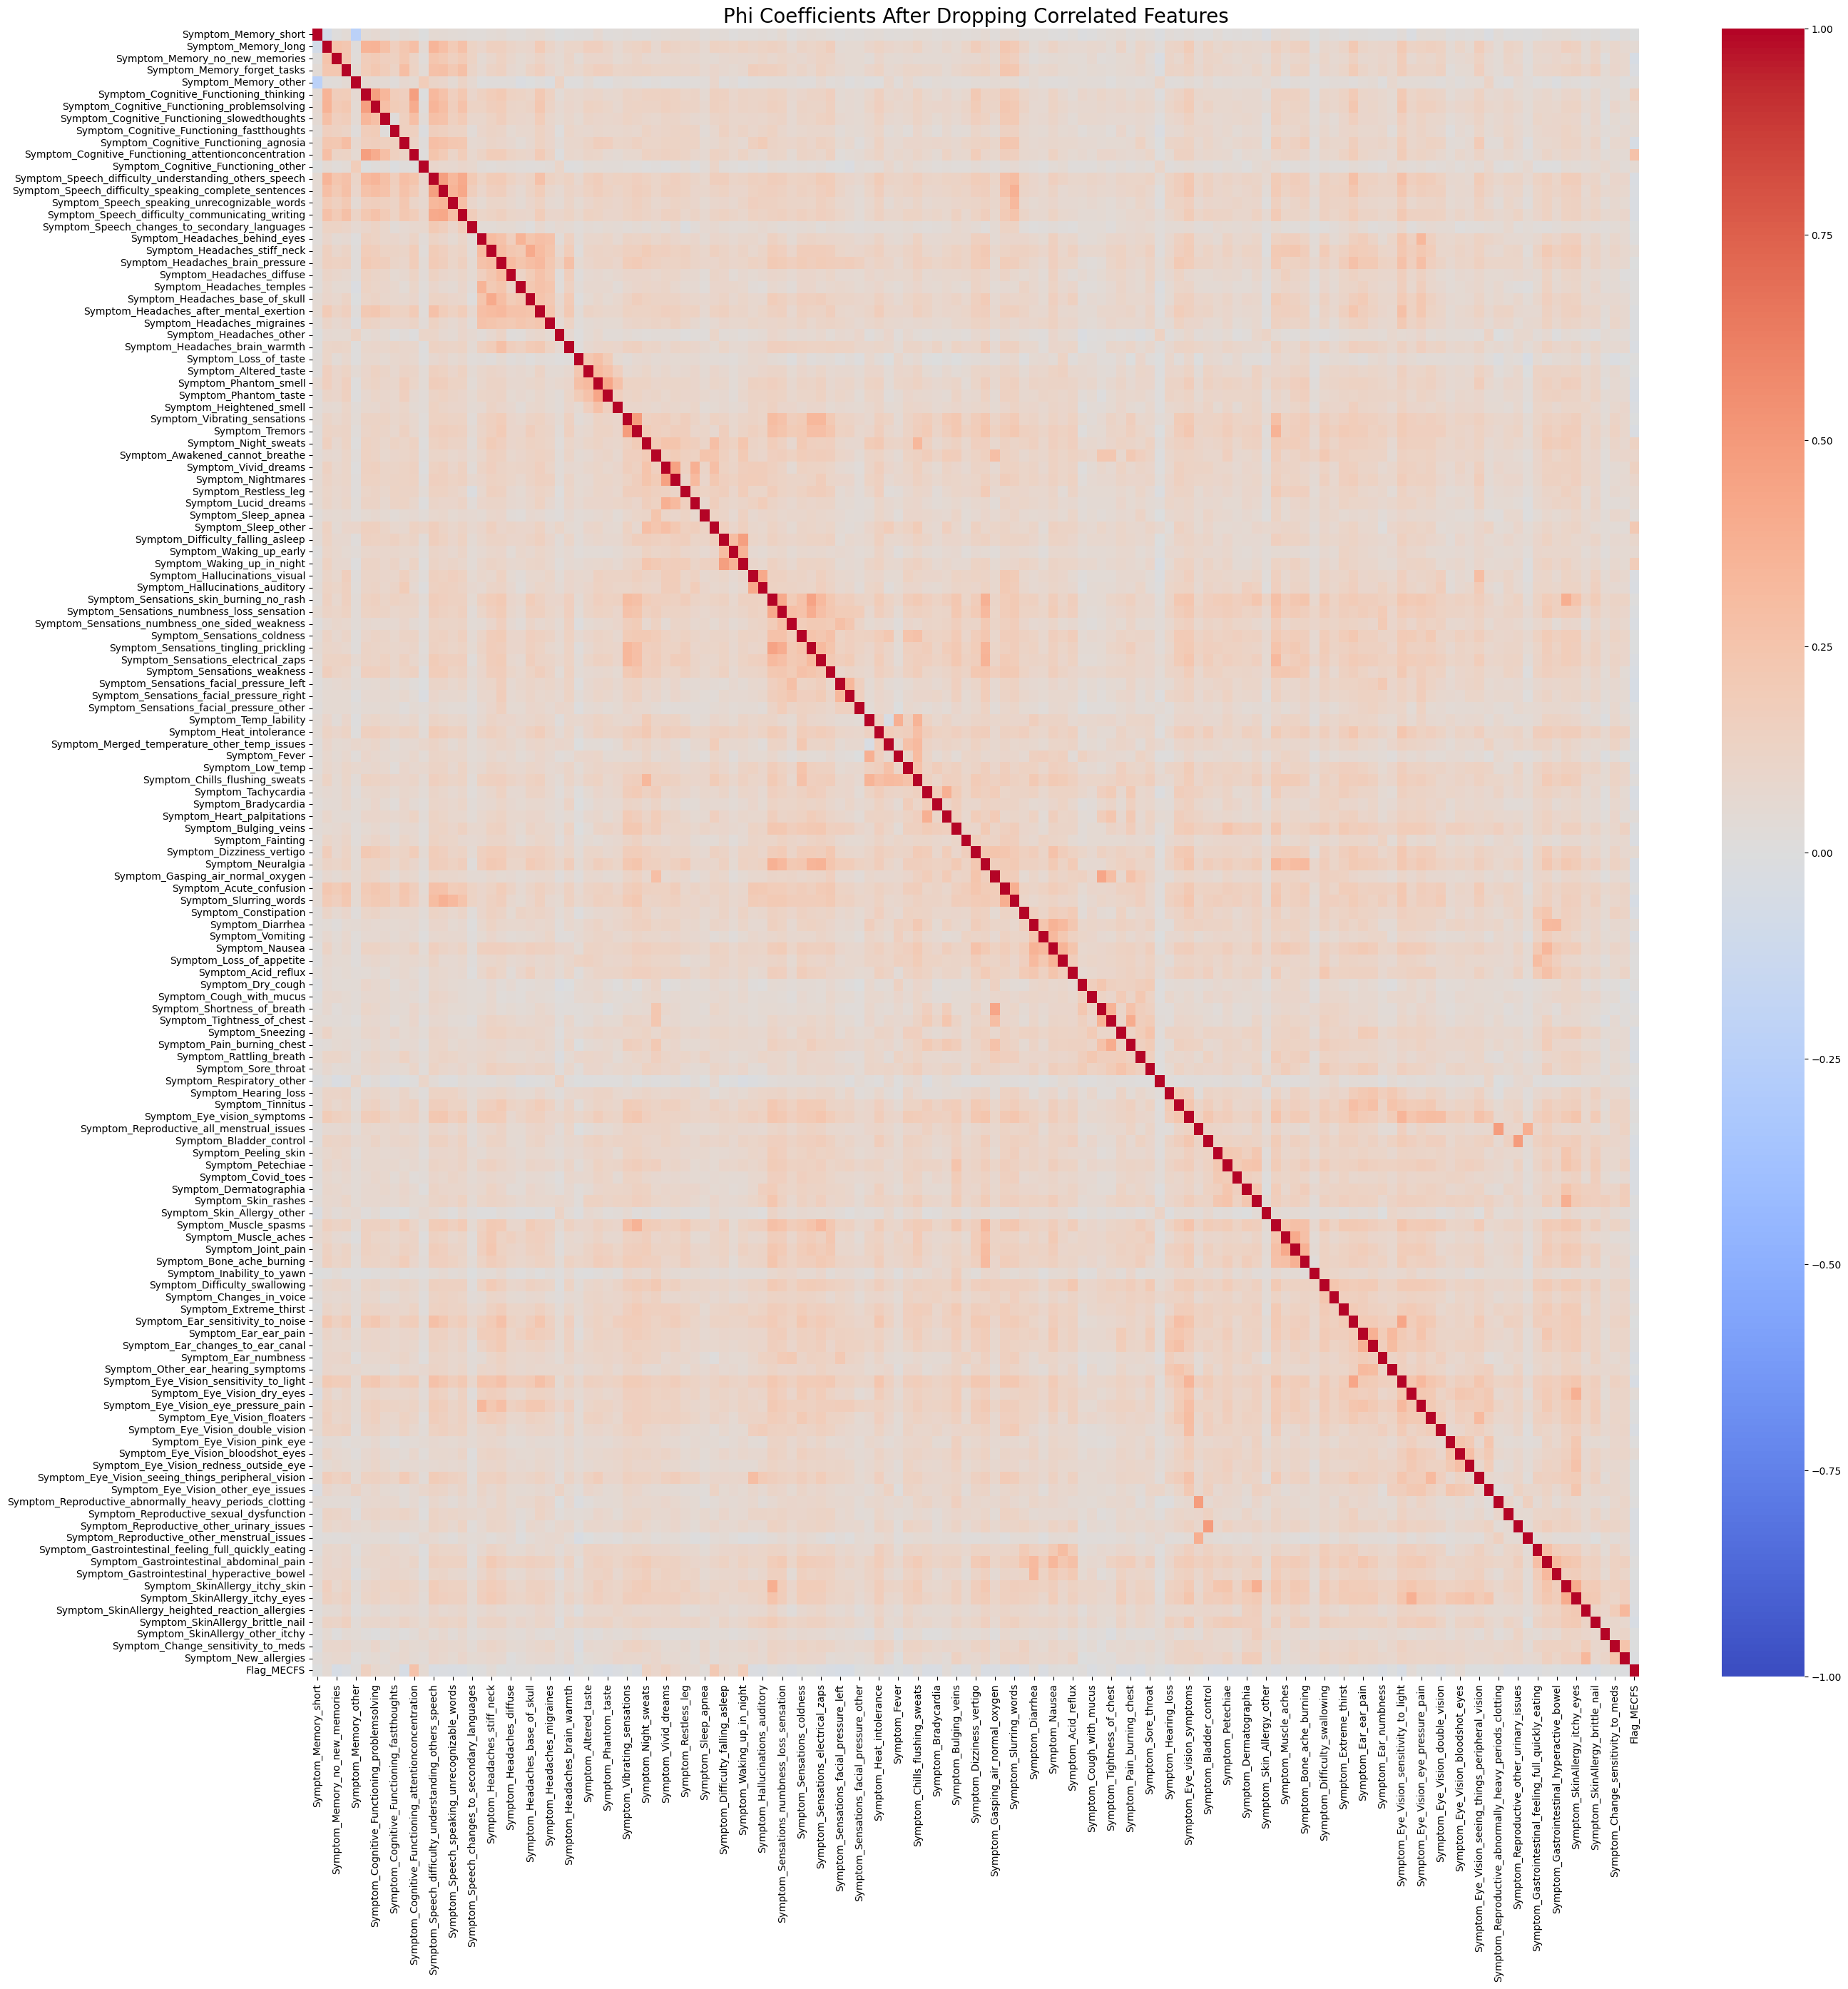

In [12]:
# Initialize an empty dataframe to store phi values for the remaining features
phi_values_after_drop = pd.DataFrame(index=data_drop_corr.columns, columns=data_drop_corr.columns)

# Calculate phi values
for col1 in data_drop_corr.columns:
    for col2 in data_drop_corr.columns:
        contingency_table = pd.crosstab(data_drop_corr[col1], data_drop_corr[col2])
        phi = phi_coefficient(contingency_table)
        phi_values_after_drop.loc[col1, col2] = phi

# Convert to float
phi_values_after_drop = phi_values_after_drop.astype(float)

# Plot heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(phi_values_after_drop, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Phi Coefficients After Dropping Correlated Features", fontsize=20)
plt.show()

In [13]:
#Of the features that are left over, lets look at the ones that are most correlated and least correlated. Useful for deciding on better
#thresholds for dropping features. 

def print_correlated_features(phi_values_df, n=5):
    
    # Flatten the Phi values DataFrame and reset the index
    phi_melted = phi_values_df.reset_index().melt(id_vars='index', var_name='Column2', value_name='Phi')
    
    # Remove self-correlations (where Phi is 1)
    phi_melted = phi_melted[phi_melted['index'] != phi_melted['Column2']]
    
    # Remove duplicate pairs
    phi_melted['Pair'] = phi_melted.apply(lambda row: tuple(sorted([row['index'], row['Column2']])), axis=1)
    phi_melted = phi_melted.drop_duplicates(subset='Pair')
    
    # Sort by Phi value
    phi_melted = phi_melted.sort_values(by='Phi')
    
    # Prepare lines for least correlated pairs
    lines = ["Negatively Correlated Features"]
    is_title = [True]
    for _, row in phi_melted.head(n).iterrows():
        lines.append(f"{row['index']} - {row['Column2']}: {row['Phi']}")
        is_title.append(False)
    print_boxed_text(lines, is_title)
    
    print()
    
    # Prepare lines for most correlated pairs
    lines = ["Positively Correlated Features"]
    is_title = [True]
    for _, row in phi_melted.tail(n).sort_values(by='Phi', ascending=False).iterrows():
        lines.append(f"{row['index']} - {row['Column2']}: {row['Phi']}")
        is_title.append(False)
    print_boxed_text(lines, is_title)

print_correlated_features(phi_values_after_drop, n=5)


┌───────────────────────────────────────────────────────────────────────────┐
├───────────────────────────────────────────────────────────────────────────┤
│                       Negatively Correlated Features                      │
├───────────────────────────────────────────────────────────────────────────┤
│                                                                           │
│ Symptom_Memory_other - Symptom_Memory_short: -0.22668082895324307         │
│ Symptom_Memory_long - Symptom_Memory_short: -0.08209996722257372          │
│ Flag_MECFS - Symptom_Slurring_words: -0.052930963762296154                │
│ Flag_MECFS - Symptom_Sensations_facial_pressure_left: -0.0513666663515984 │
│ Flag_MECFS - Symptom_Cognitive_Functioning_agnosia: -0.050269394464481656 │
└───────────────────────────────────────────────────────────────────────────┘

┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
├─────────────────

## Hierarchical Clustering

Interesting just to see in a very simple way how features are grouping together.

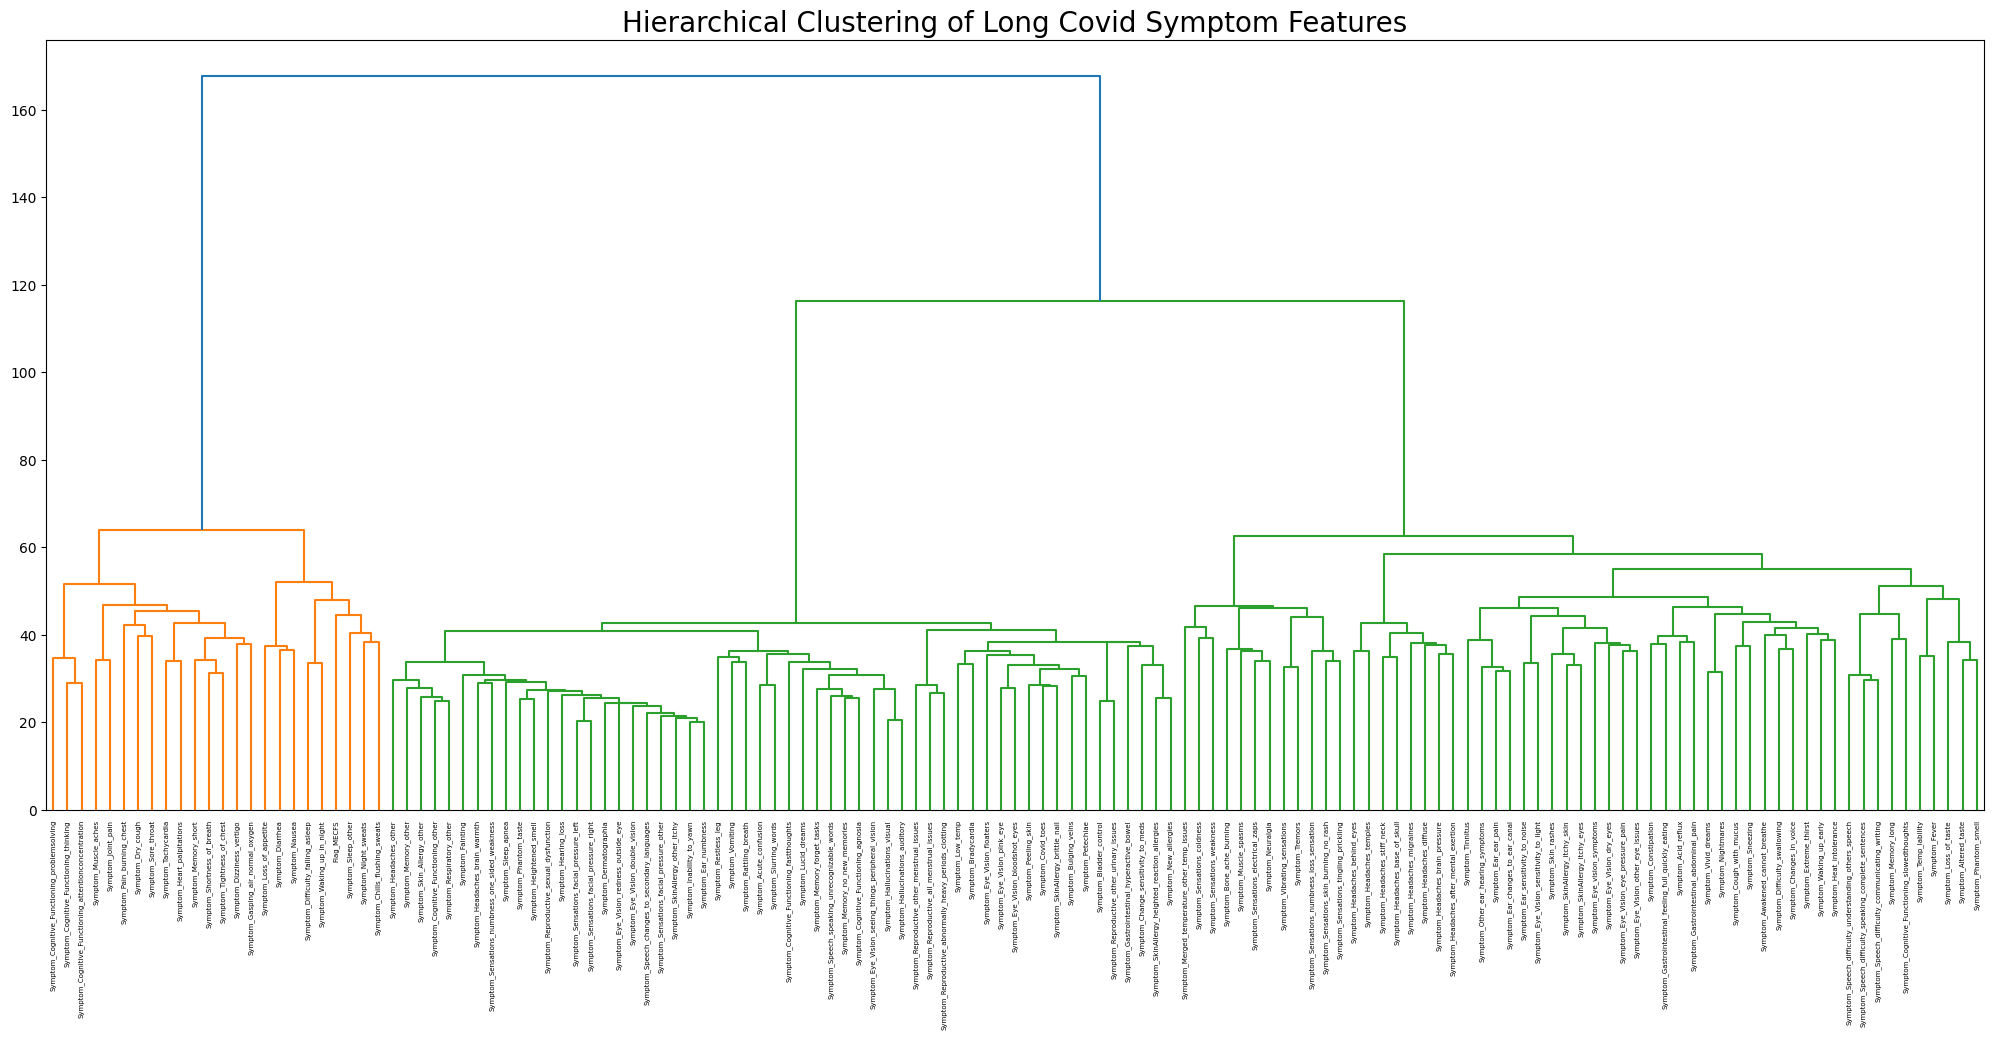

In [14]:
# Create a temporary copy
temp_data = data_drop_corr.dropna()  # Or use temp_data = data.fillna(0)

feature_names = temp_data.columns.tolist()
# Create linkage matrix and dendrogram
Z = linkage(temp_data.T, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z, labels=feature_names)

plt.title("Hierarchical Clustering of Long Covid Symptom Features", size=20)
plt.show()

In [15]:
k = 6  # Setting this based mainly off of intuition I tried caluclating inconsistency coefficient but it was not very helpful
labels = fcluster(Z, k, criterion='maxclust')
clustered_features = pd.Series(index=feature_names, data=labels).sort_values()

# Convert the pandas Series to a list of strings
lines = clustered_features.to_string().split('\n')

# Save the list of strings to a text file using save_boxed_text_to_file
save_boxed_text_to_file(lines, filename="output_tables/clustered_features.txt")

### Programmatic Analysis of Clusters

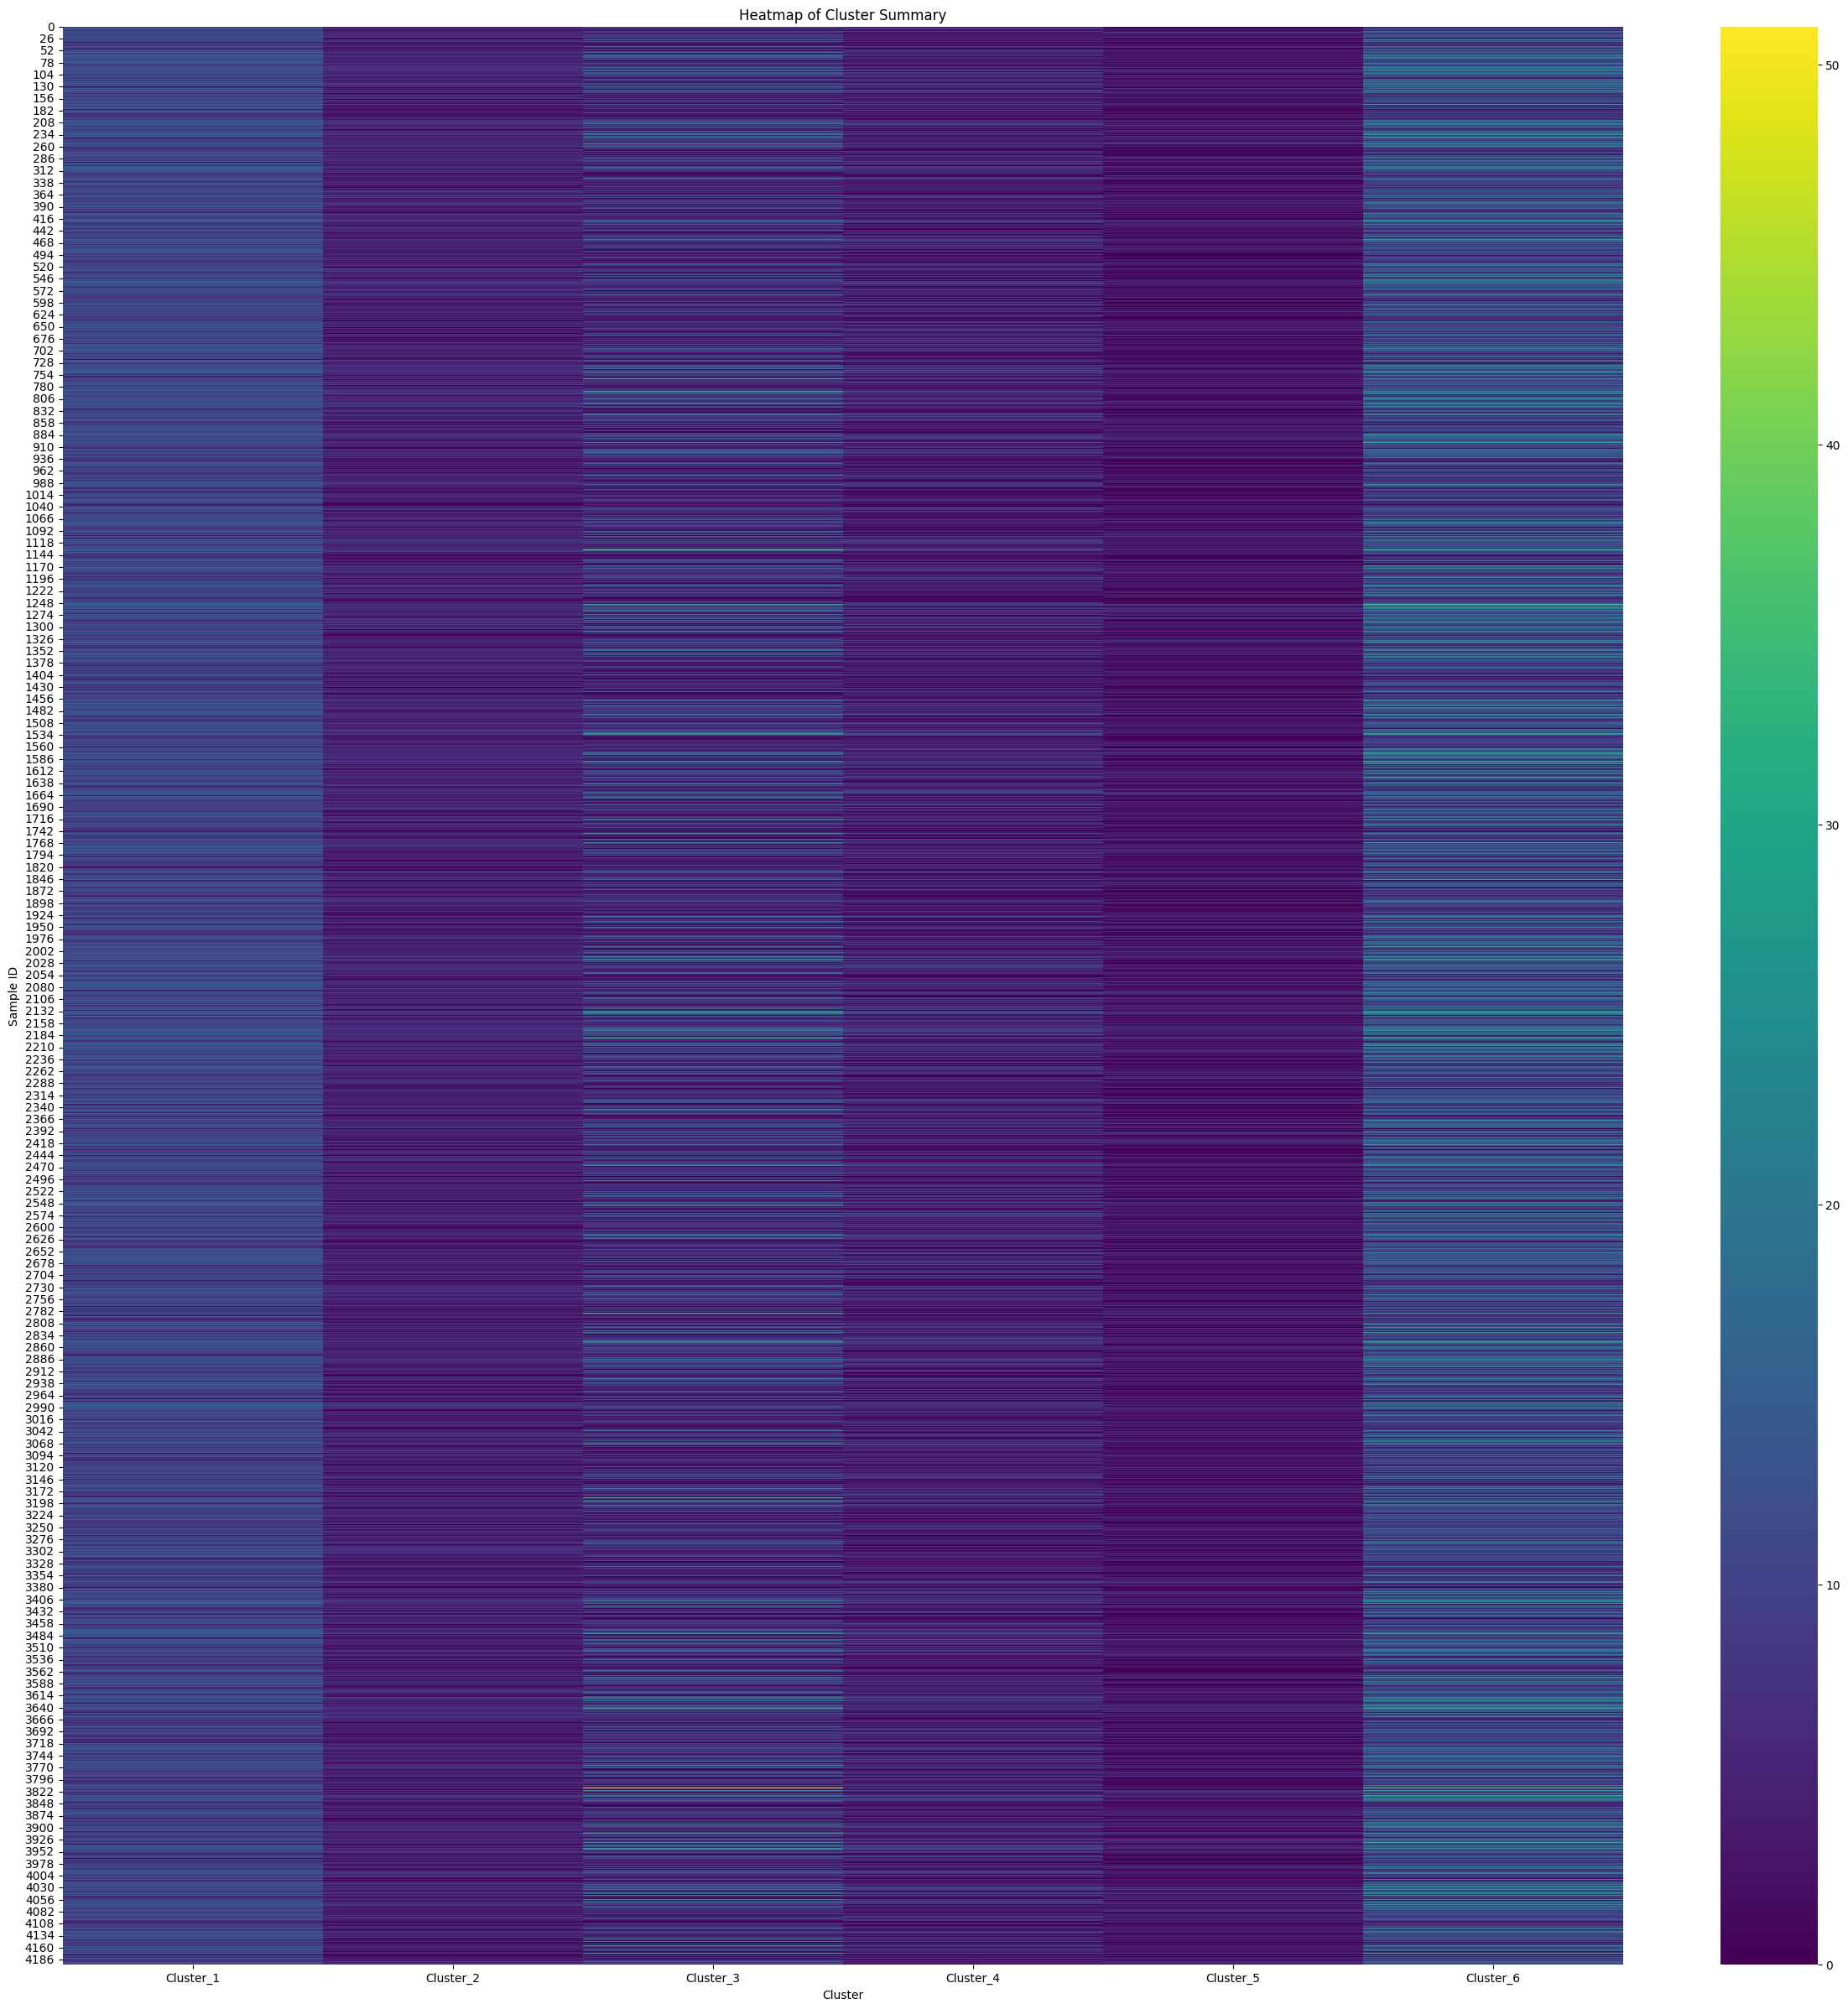

In [16]:
# Create an empty DataFrame to hold the cluster summary
cluster_summary = pd.DataFrame()

# Loop through unique cluster labels
for cluster_label in clustered_features.unique():
    # Find the columns that belong to the cluster
    cluster_columns = clustered_features[clustered_features == cluster_label].index.tolist()
    
    # Sum (or find the mean) of these columns and store in cluster_summary
    cluster_summary[f'Cluster_{cluster_label}'] = data_drop_corr[cluster_columns].sum(axis=1)

plt.figure(figsize=(30, 30))
sns.heatmap(cluster_summary, cmap='viridis', annot=False, fmt=".0f")
plt.title("Heatmap of Cluster Summary")
plt.xlabel("Cluster")
plt.ylabel("Sample ID")
plt.show()

In [17]:
# Calculate the prevalence of each cluster
cluster_prevalence = cluster_summary.mean().sort_values(ascending=False)

#conterting to string for pretty print
cluster_prevalence_str = str(cluster_prevalence).split('\n')

# Add the title line
lines = ['Prevalence of each cluster in the population:'] + cluster_prevalence_str

# Apply the print_boxed_text function
print_boxed_text(lines, is_title=[True] + [False]*len(cluster_prevalence_str))


┌───────────────────────────────────────────────┐
├───────────────────────────────────────────────┤
│ Prevalence of each cluster in the population: │
├───────────────────────────────────────────────┤
│                                               │
│ Cluster_6    11.912297                        │
│ Cluster_1    10.370591                        │
│ Cluster_3     7.596759                        │
│ Cluster_4     4.815300                        │
│ Cluster_2     4.703765                        │
│ Cluster_5     2.870353                        │
│ dtype: float64                                │
└───────────────────────────────────────────────┘


## Dimensionality Reduction

### PCA

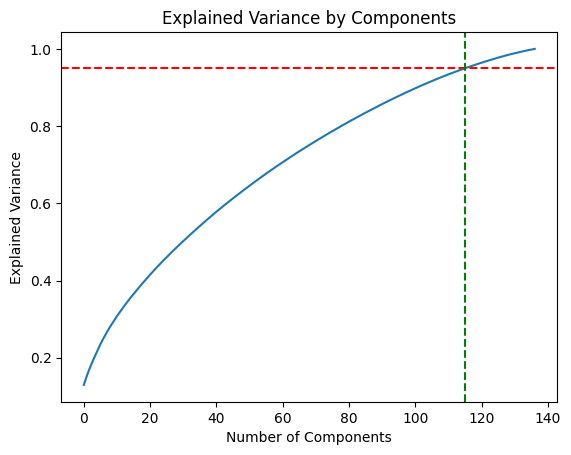

┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                               The optimal number of components is: 116                                               │
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                                                                                                                      │
│ The optimal number of components is calculated based on the point where the cumulative explained variance crosses the 95% threshold. │
└──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘


In [18]:
# Fit and transform the data
pca = PCA()
X_pca = pca.fit_transform(temp_data)

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Find the optimal number of components
optimal_n_components = np.argmax(cumulative_variance >= 0.95) + 1

# Plot explained variance
plt.plot(cumulative_variance)
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axvline(x=optimal_n_components - 1, color='g', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

# Create a list of strings to print
lines_to_print = [
    "The optimal number of components is: {}".format(optimal_n_components),
    "The optimal number of components is calculated based on the point where the cumulative explained variance crosses the 95% threshold."
]

# Use the print_boxed_text function
print_boxed_text(lines_to_print, is_title=[True, False])


In [19]:
# Display the loadings (components)
loadings = pd.DataFrame(pca.components_, columns=data_drop_corr.columns)
# Show top 10 variables for the first 10 components
# Create an empty list to hold lines for saving
lines_to_save = []

# Add title
lines_to_save.append("Top Contributors for Each Principal Component")
is_title = [True]

# Show top 10 variables for the first 6 components
for i in range(10): 
    component_title = f"Top contributors for component {i+1}"
    lines_to_save.append(component_title)
    is_title.append(True)
    
    top_contributors = loadings.loc[i].sort_values(ascending=False).head(10)
    
    for feature, loading in top_contributors.items():
        line = f"{feature}: {loading:.4f}"
        lines_to_save.append(line)
        is_title.append(False)
        
    # Add empty line for separation
    lines_to_save.append(" ")
    is_title.append(False)

# Save all lines to the same text file
save_boxed_text_to_file(lines_to_save, is_title=is_title, filename="output_tables/top_contributors.txt")


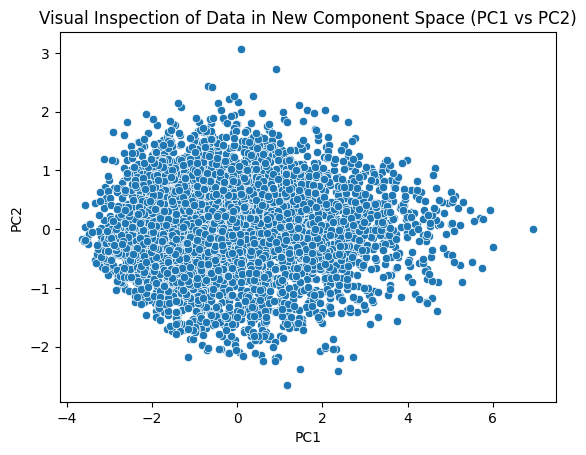

In [20]:
# Converting the PCA results that I got above to a dataframe
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# Scatter plot for first two principal components
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
plt.title('Visual Inspection of Data in New Component Space (PC1 vs PC2)')
plt.show()

### Feature Grouping

Based on the [`top_contributors.txt`](./output_tables/top_contributors.txt) file, which shows the top 10 features contributing to each of the first 10 principal components, as well as the clusters found in the  [`clustered_features.txt`](./output_tables/clustered_features.txt), as well as some domain knowledge, the following feature groupings are proposed to reduce dimensionality:


#### Table of Contents
1. [Neuro-Sensory Symptoms](#Neuro-Sensory-Symptoms)
2. [Cognitive and Memory-Related Symptoms](#Cognitive-and-Memory-Related-Symptoms)
3. [Gastrointestinal and Appetite Issues](#Gastrointestinal-and-Appetite-Issues)
4. [Respiratory and Cardiac Symptoms](#Respiratory-and-Cardiac-Symptoms)
5. [Symptoms Related to Eyes and Vision](#Symptoms-Related-to-Eyes-and-Vision)
6. [Methodological Considerations in Symptom Grouping](#Methodological-Considerations-in-Symptom-Grouping)


---

#### Neuro-Sensory Symptoms

- Symptom_Sensations_skin_burning_no_rash
- Symptom_Sensations_tingling_prickling
- Symptom_Sensations_numbness_loss_sensation
- Symptom_Vibrating_sensations
- Symptom_Tremors
- Symptom_Sensations_electrical_zaps
- Symptom_Neuralgia
- Symptom_Muscle_spasms

**Rationale:** These symptoms were mainly clustered under Component 3 in the PCA analysis, indicating that they share a good amount of variance and could be collectively representing a 'Neuro-Sensory' factor. Hierarchical clustering did not offer much information for these particular symptoms as they were spread across clusters.

---

#### Cognitive and Memory-Related Symptoms

- Symptom_Memory_long
- Symptom_Cognitive_Functioning_executive
- Symptom_Speech_difficulty_finding_words
- Symptom_Cognitive_Functioning_slowedthoughts
- Symptom_Cognitive_Functioning_attentionconcentration
- Symptom_Memory_short

**Rationale:** Component 2 from the PCA strongly associates with cognitive function and memory symptoms. Most of the symptoms in this category appear as top contributors for Component 2. No single cluster was devoted to these symptoms in the hierarchical clustering, thus relying primarily on PCA information.

---

#### Gastrointestinal and Appetite Issues

- Symptom_Gastrointestinal_abdominal_pain
- Symptom_Nausea
- Symptom_Diarrhea
- Symptom_Gastrointestinal_hyperactive_bowel
- Symptom_Gastrointestinal_feeling_full_quickly_eating
- Symptom_Loss_of_appetite

**Rationale:** These symptoms are mainly grouped based on Component 4 of the PCA. They all pertain to digestive system issues and appetite, making them conceptually coherent as well. The hierarchical clustering spread these symptoms across different clusters, so they were not considered for the formation of this group.

---

#### Respiratory and Cardiac Symptoms

- Symptom_Shortness_of_breath
- Symptom_Tightness_of_chest
- Symptom_Tachycardia
- Symptom_Heart_palpitations
- Symptom_Gasping_air_normal_oxygen
- Symptom_PEM

**Rationale:** These symptoms primarily belong to Cluster 2 in the hierarchical clustering. They also have a shared theme of respiratory and cardiac issues, making them logically coherent to group together.

---

#### Symptoms Related to Eyes and Vision

- Symptom_Eye_Vision_sensitivity_to_light
- Symptom_Eye_Vision_dry_eyes
- Symptom_Eye_Vision_eye_pressure_pain
- Symptom_SkinAllergy_itchy_eyes
- Symptom_Eye_Vision_other_eye_issues

**Rationale:** These symptoms are mainly grouped based on their contribution to Component 1 and Component 6 in PCA. They all pertain to eye and vision issues, making them conceptually coherent as well.

---
<h4 id="Methodological-Considerations-in-Symptom-Grouping"><u>Methodological Considerations in Symptom Grouping</u></h4>

##### Comparative Approaches for Symptom Grouping: Binary Feature Aggregation versus Conditional Activation Aggregation
Effective symptom grouping is a critical challenge in patient stratification within bioinformatics. Traditional approaches often consider the presence of any individual symptom within a predefined set as sufficient for categorizing a patient under a particular symptom group. While straightforward, this method may not capture the complexities or specificities of a patient's condition. To better address this issue, a novel approach, termed 'Conditional Activation Aggregation,' is introduced.

##### Binary Feature Aggregation
In the Binary Feature Aggregation method, the presence of any constituting symptom results in the aggregated symptom group being tagged as '1' for a given patient. Essentially, this approach serves as a type of "OR" gate for the individual symptoms in a symptom group. Mathematically, this can be formalized as a logical disjunction operation over the individual symptoms that make up the group.

##### Conditional Activation Aggregation
The Conditional Activation Aggregation method represents a more nuanced approach. In this case, the symptom group is only tagged as '1' if a specific number of constituting symptoms are present, effectively serving as a kind of activation function for symptom grouping. A Rectified Linear Unit (ReLU)-like function can be applied to map the symptoms to a binary outcome. This ensures that only the simultaneous presence of multiple symptoms triggers the 'activation' of the symptom group.


In [21]:
# Creating a copy for the non-additive grouping
data_grouped = data_drop_corr.copy()

# Creating another copy for the additive grouping
data_grouped_additive = data_drop_corr.copy()

neuro_sensory_symptoms = [
    'Symptom_Sensations_skin_burning_no_rash', 
    'Symptom_Sensations_tingling_prickling', 
    'Symptom_Sensations_numbness_loss_sensation', 
    'Symptom_Vibrating_sensations', 
    'Symptom_Tremors', 
    'Symptom_Sensations_electrical_zaps',
    'Symptom_Neuralgia',
    'Symptom_Muscle_spasms'
]

cognitive_memory_symptoms = [
    'Symptom_Memory_long',
    'Symptom_Cognitive_Functioning_problemsolving',
    'Symptom_Speech_difficulty_understanding_others_speech',
    'Symptom_Cognitive_Functioning_slowedthoughts',
    'Symptom_Cognitive_Functioning_attentionconcentration',
    'Symptom_Memory_short'
]

gastrointestinal_symptoms = [
    'Symptom_Gastrointestinal_abdominal_pain',
    'Symptom_Nausea',
    'Symptom_Diarrhea',
    'Symptom_Gastrointestinal_hyperactive_bowel',
    'Symptom_Gastrointestinal_feeling_full_quickly_eating',
    'Symptom_Loss_of_appetite'
]

respiratory_cardiac_symptoms = [
    'Symptom_Shortness_of_breath',
    'Symptom_Tightness_of_chest',
    'Symptom_Tachycardia',
    'Symptom_Heart_palpitations',
    'Symptom_Gasping_air_normal_oxygen',
    #'Symptom_PEM'
]

eye_vision_symptoms = [
    'Symptom_Eye_Vision_sensitivity_to_light',
    'Symptom_Eye_Vision_dry_eyes',
    'Symptom_Eye_Vision_eye_pressure_pain',
    'Symptom_SkinAllergy_itchy_eyes',
    'Symptom_Eye_Vision_other_eye_issues'
]

# Function to create grouped symptoms using "any" criteria
def create_grouped_symptoms(df, symptom_list, new_column_name):
    df[new_column_name] = df[symptom_list].apply(lambda row: 1 if any(row) else 0, axis=1)
    df.drop(columns=symptom_list, inplace=True)

# Function to create grouped symptoms using "additive" criteria
def create_grouped_symptoms_additive(df, symptom_list, new_column_name, threshold=0.5):
    df[new_column_name + "_sum"] = df[symptom_list].apply(np.sum, axis=1)
    df[new_column_name] = df[new_column_name + "_sum"].apply(lambda x: 1 if x > threshold else 0)
    df.drop(columns=[new_column_name + "_sum"] + symptom_list, inplace=True)

# Create grouped symptoms for non-additive dataframe
for symptom_list, new_column_name in zip([neuro_sensory_symptoms, cognitive_memory_symptoms, gastrointestinal_symptoms, respiratory_cardiac_symptoms, eye_vision_symptoms],
                                        ['Grouped_Neuro_Sensory', 'Grouped_Cognitive_Memory', 'Grouped_Gastrointestinal', 'Grouped_Respiratory_Cardiac', 'Grouped_Eye_Vision']):
    create_grouped_symptoms(data_grouped, symptom_list, new_column_name)

# Create grouped symptoms for additive dataframe
for symptom_list, new_column_name in zip([neuro_sensory_symptoms, cognitive_memory_symptoms, gastrointestinal_symptoms, respiratory_cardiac_symptoms, eye_vision_symptoms],
                                        ['Grouped_Neuro_Sensory', 'Grouped_Cognitive_Memory', 'Grouped_Gastrointestinal', 'Grouped_Respiratory_Cardiac', 'Grouped_Eye_Vision']):
    create_grouped_symptoms_additive(data_grouped_additive, symptom_list, new_column_name, threshold=3)

# Save the dataframes to CSV files
data_grouped.to_csv("data/skew_corr_group.csv", index=False)
data_grouped_additive.to_csv("data/skew_corr_groupadd.csv", index=False)


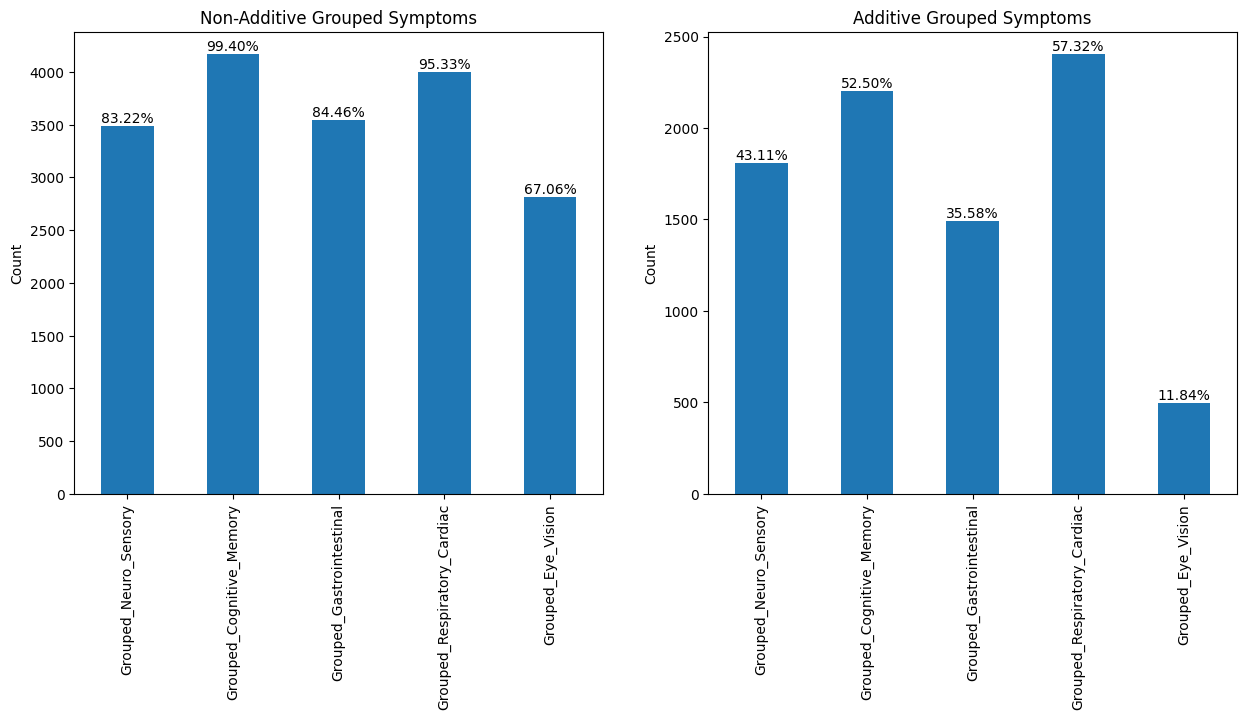

In [22]:
# Assume data_grouped and data_grouped_additive are your DataFrames and grouped_symptoms are the columns to plot
grouped_symptoms = ['Grouped_Neuro_Sensory', 'Grouped_Cognitive_Memory', 'Grouped_Gastrointestinal', 'Grouped_Respiratory_Cardiac', 'Grouped_Eye_Vision']

# Calculate the sums for non-additive and additive data
sums_non_additive = data_grouped[grouped_symptoms].sum()
sums_additive = data_grouped_additive[grouped_symptoms].sum()

# Calculate the total number of patients in the study
total_patients = len(data_grouped)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for non-additive data
ax1 = sums_non_additive.plot(kind='bar', ax=axes[0])
axes[0].set_title('Non-Additive Grouped Symptoms')
axes[0].set_ylabel('Count')

# Annotate each bar with the percentage
for i, value in enumerate(sums_non_additive):
    percentage = (value / total_patients) * 100
    axes[0].text(i, value, f"{percentage:.2f}%", ha='center', va='bottom')

# Plot for additive data
ax2 = sums_additive.plot(kind='bar', ax=axes[1])
axes[1].set_title('Additive Grouped Symptoms')
axes[1].set_ylabel('Count')

# Annotate each bar with the percentage
for i, value in enumerate(sums_additive):
    percentage = (value / total_patients) * 100
    axes[1].text(i, value, f"{percentage:.2f}%", ha='center', va='bottom')

# Show plots
plt.show()
